In [1]:
import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Corrected import statement
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
os.chdir('E:\Mylearning\eye_prediction\dataset')

In [4]:
# Define rescaling layer
rescale = tf.keras.layers.Rescaling(1./255)

# Load train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory='E:/Mylearning/eye_prediction/dataset',
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,
    subset="training",
    seed=123,
    label_mode='categorical',  # Assuming you have multiple classes
)

# Preprocess train dataset (rescale)
train_ds = train_ds.map(lambda x, y: (rescale(x), y))

# Load validation dataset
validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory='E:/Mylearning/eye_prediction/dataset',
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,
    subset="validation",
    seed=123,
    label_mode='categorical',  # Assuming you have multiple classes
)

# Preprocess validation dataset (rescale)
validation_ds = validation_ds.map(lambda x, y: (rescale(x), y))

# Load test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory='E:/Mylearning/eye_prediction/dataset',  # Specify the directory for the test dataset
    batch_size=32,
    image_size=(256, 256),
    label_mode='categorical',  # Assuming you have multiple classes
    shuffle=False,
)

# Preprocess test dataset (rescale)
test_ds = test_ds.map(lambda x, y: (rescale(x), y))

Found 4217 files belonging to 4 classes.
Using 3374 files for training.
Found 4217 files belonging to 4 classes.
Using 843 files for validation.
Found 4217 files belonging to 4 classes.


In [5]:
# Check the first image shape in the training dataset
print("Shape of the first image in the training dataset:", next(iter(train_ds))[0][0].shape)
# Check the first image shape in the validation dataset
print("Shape of the first image in the validation dataset:", next(iter(validation_ds))[0][0].shape)
# Check the first image shape in the test dataset
print("Shape of the first image in the test dataset:", next(iter(test_ds))[0][0].shape)

Shape of the first image in the training dataset: (256, 256, 3)
Shape of the first image in the validation dataset: (256, 256, 3)
Shape of the first image in the test dataset: (256, 256, 3)


In [7]:
# Initialize variables to store minimum and maximum pixel values
min_pixel_value = float('inf')
max_pixel_value = float('-inf')

# Iterate through the dataset
for images, _ in train_ds:
    # Compute the minimum and maximum pixel values in the current batch of images
    batch_min = tf.reduce_min(images)
    batch_max = tf.reduce_max(images)
    
    # Update overall minimum and maximum pixel values
    min_pixel_value = tf.minimum(min_pixel_value, batch_min)
    max_pixel_value = tf.maximum(max_pixel_value, batch_max)

# Print the minimum and maximum pixel values
print("Minimum pixel value:", min_pixel_value.numpy())
print("Maximum pixel value:", max_pixel_value.numpy())

Minimum pixel value: 0.0
Maximum pixel value: 1.0


In [8]:
def visualize_images(path, target_size=(256, 256), num_images=5):

    # Get a list of image filenames
    image_filenames = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

    if not image_filenames:
        raise ValueError("No images found in the specified path")

    # Select random images
    selected_images = random.sample(image_filenames, min(num_images, len(image_filenames)))

    # Create a figure and axes
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')

    # Display each image
    for i, image_filename in enumerate(selected_images):
        # Load image and resize
        image_path = os.path.join(path, image_filename)
        image = Image.open(image_path)
        image = image.resize(target_size)

        # Display image
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(image_filename)  # Set image filename as title

    # Adjust layout and display
    plt.tight_layout()
    plt.show()



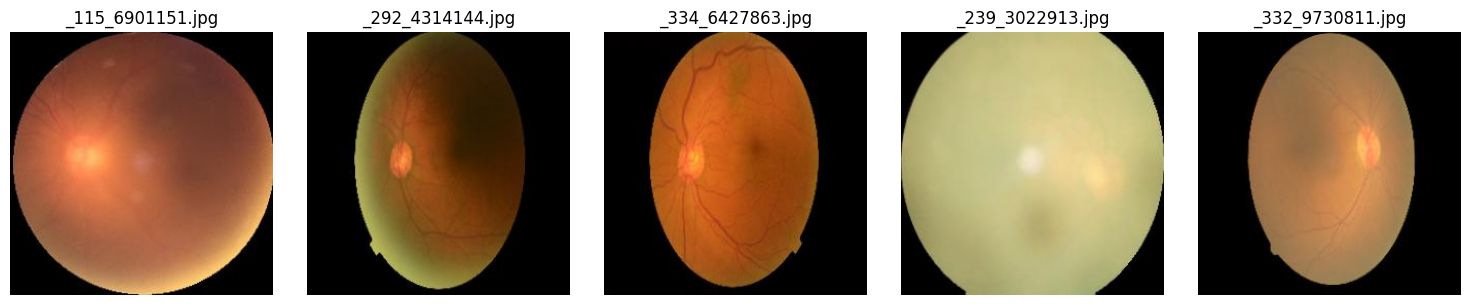

In [11]:
# Specify the path containing the images to visualize
path_to_visualize = 'E:/Mylearning/eye_prediction/dataset/cataract'

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

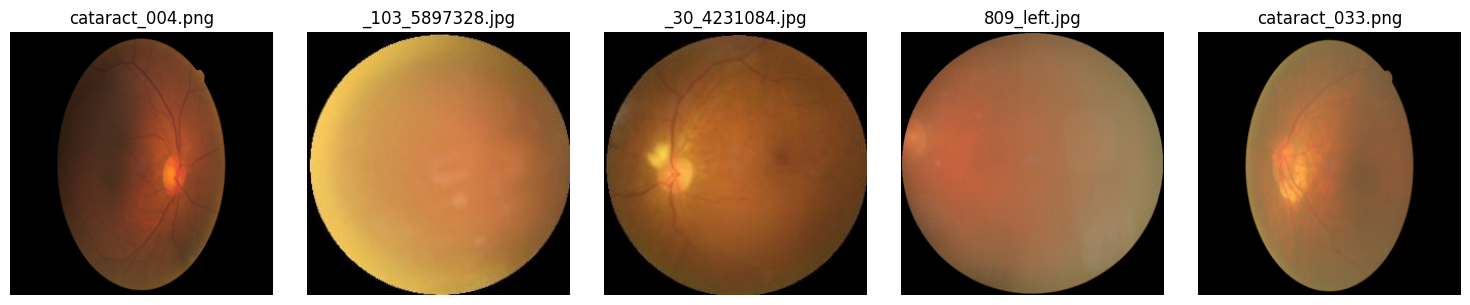

In [12]:
# Specify the path containing the images to visualize
path_to_visualize ='E:/Mylearning/eye_prediction/dataset/cataract'

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

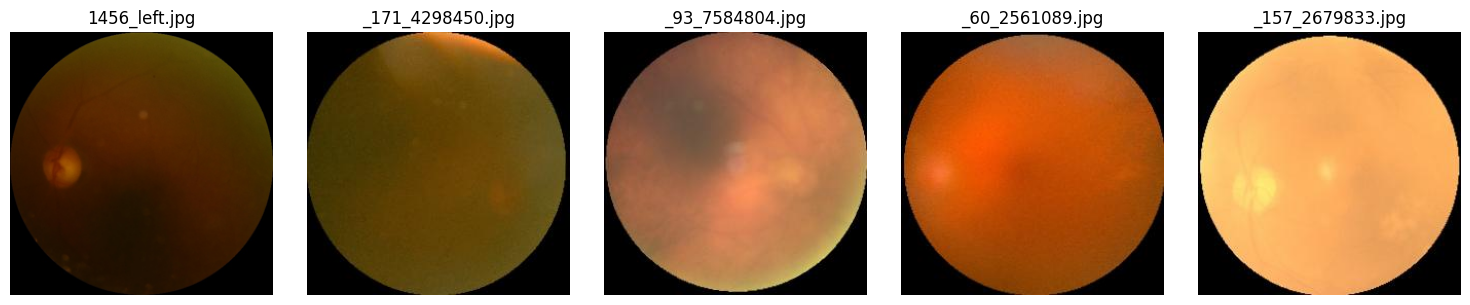

In [13]:
# Specify the path containing the images to visualize
path_to_visualize = 'E:/Mylearning/eye_prediction/dataset/cataract'

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

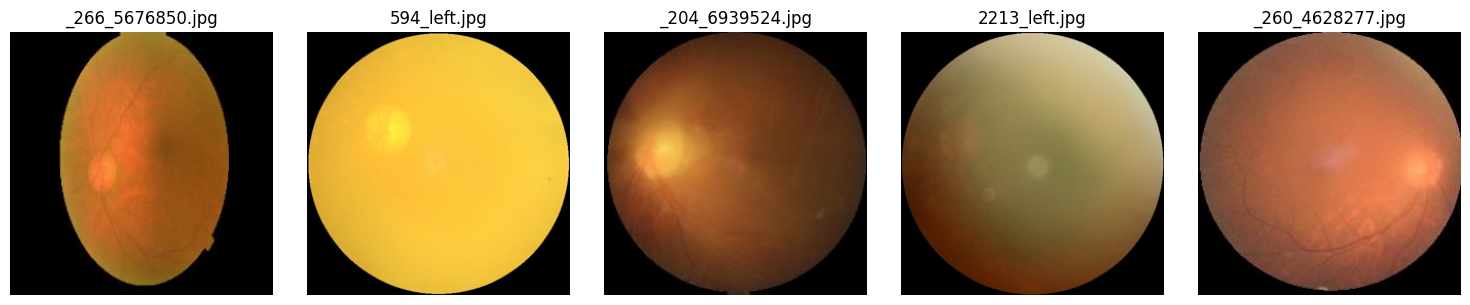

In [14]:
# Specify the path containing the images to visualize
path_to_visualize = 'E:/Mylearning/eye_prediction/dataset/cataract'

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)


In [15]:
# Define RNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Reshape((64, 1)),  # Reshape for RNN input
    tf.keras.layers.SimpleRNN(32),  # Simple RNN layer
    tf.keras.layers.Dense(4, activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,744,004 (14.28 MB)

 Trainable params: 3,744,004 (14.28 MB)

 Non-trainable params: 0 (0.00 B)

None


In [16]:
# Define early stopping callback
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Fit the model with callbacks
history = model.fit(train_ds,
                    validation_data=validation_ds,
                    epochs=5,
                    callbacks=[early_stopping])

Epoch 1/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 101s 915ms/step - accuracy: 0.4626 - loss: 1.1494 - val_accuracy: 0.6002 - val_loss: 0.8174
Epoch 2/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 102s 955ms/step - accuracy: 0.6287 - loss: 0.7744 - val_accuracy: 0.6679 - val_loss: 0.7077
Epoch 3/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 96s 900ms/step - accuracy: 0.6631 - loss: 0.7119 - val_accuracy: 0.7023 - val_loss: 0.6710
Epoch 4/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 103s 965ms/step - accuracy: 0.7062 - loss: 0.6412 - val_accuracy: 0.7438 - val_loss: 0.5875
Epoch 5/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 96s 900ms/step - accuracy: 0.7567 - loss: 0.5690 - val_accuracy: 0.7414 - val_loss: 0.5973


In [17]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy:", test_accuracy)

132/132 ━━━━━━━━━━━━━━━━━━━━ 28s 211ms/step - accuracy: 0.7141 - loss: 0.5897
Test accuracy: 0.7552762627601624


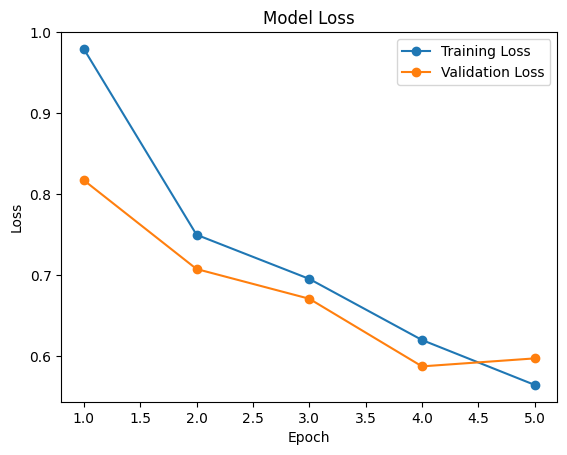

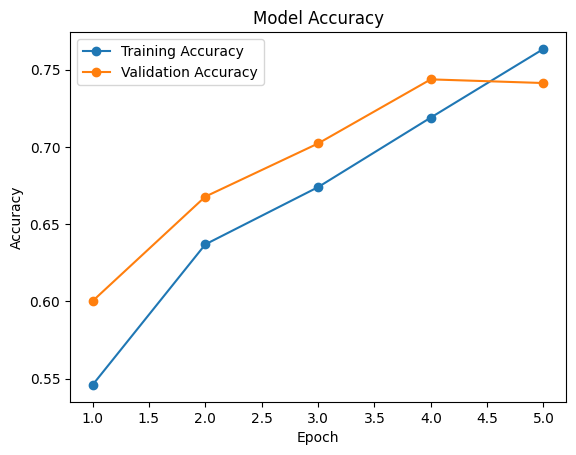

In [18]:
# Define epochs
epochs = range(1, len(history.history['loss']) + 1)

# Plot training & validation loss
plt.plot(epochs, history.history['loss'], label='Training Loss', marker='o')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation accuracy
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()